In [179]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import sys
sys.path.append('../')
import default_style

In [180]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_STFT'

In [181]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df["actor_number"] = df.actor.apply(lambda x: int(x.split("_")[1]))
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,...,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index,actor_number
0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,2.252000,...,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448,1
1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,...,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352,1
2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,2.238500,...,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352,1
3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,2.187167,...,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064,1
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,...,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056,1


In [182]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

# SORRY PAOLINO BUT I HAVE A CHICCO PC AND I CANNOT LOAD IT ALL

# for file in files:

#     if file.endswith('.npy'):
#         file_path = os.path.join(TS_PREPROC_FOLDER, file)
#         # dictionary keys are the file names
#         key = os.path.splitext(file)[0]
#         # load array
#         traces_dict[key] = np.load(file_path, allow_pickle=True)

# traces_dict.keys()

file_path = os.path.join(TS_PREPROC_FOLDER, f"{TRACES}.npy")
traces_dict[TRACES] = np.load(file_path, allow_pickle=True)


In [183]:
traces = traces_dict[TRACES]
# traces = traces.reshape(2452, 729)
traces.shape

(2452, 27, 27)

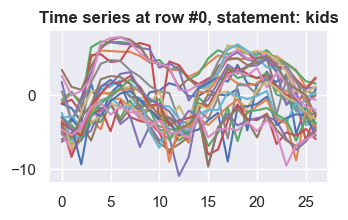

In [184]:
index = 0
statement = df['statement'][index]
plt.plot(traces[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

In [185]:
from sklearn.model_selection import train_test_split

In [186]:
# Sets tests to be over actor 19 (excluded)
X_test = traces[df.actor_number > 19]
y_test = df[TARGET][df.actor_number > 19].to_numpy()

# Sets the train and validation inside actors < 19
X_train, X_val, y_train, y_val = train_test_split(  traces[df.actor_number <= 19], 
                                                    df[TARGET][df.actor_number <= 19].to_numpy(), 
                                                    test_size=0.2, random_state=100)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1545, 27, 27), (387, 27, 27), (520, 27, 27), (1545,), (387,), (520,))

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


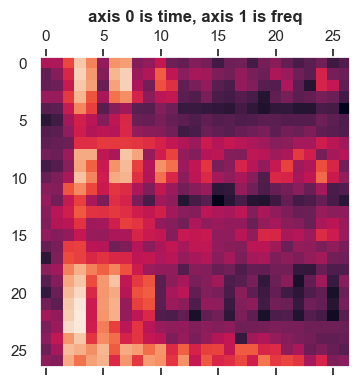

In [187]:
plt.matshow(X_test[0]);plt.grid(ls="")
plt.title("axis 0 is time, axis 1 is freq");

# CNN for statement and syllables 0&2

In [188]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [189]:
import optuna
from keras.layers import BatchNormalization, Activation
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Dropout, GlobalAveragePooling1D
from sklearn.metrics import accuracy_score

def build_model(input_shape, n_categories,
                n_conv=0, n_hidden=0, hidden_nodes=32,
                dropout=0.01, filters=8, kernel_size=5, **kwargs):
    
    # Stuff must be given in (timestep, spectral_coeff) format
    n_timesteps = input_shape[0]
    n_features = input_shape[1]

    model = Sequential()

    model.add(Conv1D(filters=filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(n_timesteps, n_features),
                     name="base_conv"
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(n_conv):
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', name=f"extra_conv_{i}"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))

        model.add(Dropout(dropout))

    model.add(GlobalAveragePooling1D())

    for i in range(n_hidden):
        model.add(Dense(hidden_nodes, activation='relu'))

    model.add(Dense(n_categories, activation='softmax'))    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [46]:
# Test to check the accuracy of a "belly" network
test_model = build_model((27,27), 2, 
                         n_conv=2, n_hidden=3, hidden_nodes=256)
test_model.summary()
test_model.fit(X_train, y_train,  verbose=True, epochs=8)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 23, 8)             1088      
                                                                 
 batch_normalization (BatchN  (None, 23, 8)            32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 23, 8)             0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 19, 8)             328       
                                                                 
 batch_normalization_1 (Batc  (None, 19, 8)            32        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 19, 8)             0

In [190]:
# objective function to be minimized
def objective_fun(trial, X, y, validation_X, validation_y):

    n_conv = trial.suggest_int('n_conv', 0, 3)
    n_hidden = trial.suggest_int('n_hidden', 0, 3)
    hidden_nodes = trial.suggest_int('hidden_nodes', 8, 256)
    dropout = trial.suggest_float('dropout', 0, 0.2)
    filters = trial.suggest_int('filters', 2, 16)
    kernel_size = trial.suggest_int('kernel_size', 2, 16)
    batch_size = trial.suggest_int('batch_size', 16, 64)
    epochs = trial.suggest_int('epochs', 5, 90)
    
    print(f"Running little bitch having n_conv={n_conv}, dropout={dropout}, hidden_nodes={hidden_nodes}")
    
    cnn = build_model(  X.shape[1:], len(np.unique(y)),
                        n_hidden=n_hidden,
                        hidden_nodes=hidden_nodes,
                        n_conv=n_conv,
                        dropout=dropout,
                        filters=filters,
                        kernel_size=kernel_size,
                       )

    cnn.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=False)
    
    y_pred = np.argmax(cnn.predict(validation_X), axis=1)

    error = accuracy_score(validation_y, y_pred)

    return error


study = optuna.create_study(direction='maximize')
trial_function = lambda trial: objective_fun(trial, 
                                             X_train, y_train,
                                             X_val, y_val)
study.optimize(trial_function, n_trials=150, n_jobs=-1, catch=ValueError)

[I 2023-06-30 16:17:58,063] A new study created in memory with name: no-name-f1feb7a8-68c1-40ad-b56c-7cd1450ae592


Running little bitch having n_conv=3, dropout=0.07279102758009641, hidden_nodes=122
Running little bitch having n_conv=3, dropout=0.163456083117766, hidden_nodes=241
Running little bitch having n_conv=0, dropout=0.019841592436477897, hidden_nodes=214
Running little bitch having n_conv=0, dropout=0.017082015961129373, hidden_nodes=169
Running little bitch having n_conv=1, dropout=0.03144416546674549, hidden_nodes=205
Running little bitch having n_conv=0, dropout=0.1344279130184962, hidden_nodes=137
Running little bitch having n_conv=2, dropout=0.045912621776041454, hidden_nodes=146
Running little bitch having n_conv=3, dropout=0.01704535579182134, hidden_nodes=115


[W 2023-06-30 16:17:58,731] Trial 0 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 122, 'dropout': 0.07279102758009641, 'filters': 12, 'kernel_size': 11, 'batch_size': 29, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 12] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=1, dropout=0.05843557599130527, hidden_nodes=248
Running little bitch having n_conv=0, dropout=0.18754512686039593, hidden_nodes=180


[W 2023-06-30 16:17:59,031] Trial 6 failed with parameters: {'n_conv': 3, 'n_hidden': 1, 'hidden_nodes': 115, 'dropout': 0.01704535579182134, 'filters': 2, 'kernel_size': 11, 'batch_size': 38, 'epochs': 83} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 2] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=1, dropout=0.08916094499939836, hidden_nodes=17
Running little bitch having n_conv=3, dropout=0.009930125254752965, hidden_nodes=177
13/13 [==============================] - 0s 5ms/step


[I 2023-06-30 16:18:15,871] Trial 9 finished with value: 0.9224806201550387 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 180, 'dropout': 0.18754512686039593, 'filters': 7, 'kernel_size': 5, 'batch_size': 25, 'epochs': 5}. Best is trial 9 with value: 0.9224806201550387.


Running little bitch having n_conv=0, dropout=0.049447975893338936, hidden_nodes=181
13/13 [==============================] - 0s 3ms/step


[I 2023-06-30 16:18:22,344] Trial 5 finished with value: 0.9612403100775194 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 137, 'dropout': 0.1344279130184962, 'filters': 9, 'kernel_size': 6, 'batch_size': 62, 'epochs': 43}. Best is trial 5 with value: 0.9612403100775194.


Running little bitch having n_conv=0, dropout=0.11425542096056365, hidden_nodes=184
13/13 [==============================] - 0s 4ms/step


[I 2023-06-30 16:18:25,333] Trial 12 finished with value: 0.9844961240310077 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 181, 'dropout': 0.049447975893338936, 'filters': 6, 'kernel_size': 10, 'batch_size': 33, 'epochs': 13}. Best is trial 12 with value: 0.9844961240310077.


Running little bitch having n_conv=2, dropout=0.1348052051928215, hidden_nodes=116


[W 2023-06-30 16:18:25,600] Trial 14 failed with parameters: {'n_conv': 2, 'n_hidden': 1, 'hidden_nodes': 116, 'dropout': 0.1348052051928215, 'filters': 15, 'kernel_size': 10, 'batch_size': 53, 'epochs': 29} because of the following error: ValueError('Exception encountered when calling layer "extra_conv_1" (type Conv1D).\n\nNegative dimension size caused by subtracting 10 from 9 for \'{{node extra_conv_1/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](extra_conv_1/Conv1D/ExpandDims, extra_conv_1/Conv1D/ExpandDims_1)\' with input shapes: [?,1,9,15], [1,10,15,15].\n\nCall arguments received by layer "extra_conv_1" (type Conv1D):\n  • inputs=tf.Tensor(shape=(None, 9, 15), dtype=float32)').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
      

Running little bitch having n_conv=0, dropout=0.11409339087166691, hidden_nodes=131
13/13 [==============================] - 0s 7ms/step


[I 2023-06-30 16:18:28,148] Trial 2 finished with value: 0.9689922480620154 and parameters: {'n_conv': 0, 'n_hidden': 3, 'hidden_nodes': 214, 'dropout': 0.019841592436477897, 'filters': 12, 'kernel_size': 15, 'batch_size': 64, 'epochs': 42}. Best is trial 12 with value: 0.9844961240310077.


Running little bitch having n_conv=0, dropout=0.062052216498724215, hidden_nodes=139
13/13 [==============================] - 0s 5ms/step


[I 2023-06-30 16:18:32,706] Trial 10 finished with value: 0.9664082687338501 and parameters: {'n_conv': 1, 'n_hidden': 0, 'hidden_nodes': 17, 'dropout': 0.08916094499939836, 'filters': 4, 'kernel_size': 6, 'batch_size': 64, 'epochs': 57}. Best is trial 12 with value: 0.9844961240310077.


Running little bitch having n_conv=0, dropout=0.14009159678445446, hidden_nodes=132
13/13 [==============================] - 0s 6ms/step


[I 2023-06-30 16:18:35,106] Trial 15 finished with value: 0.9689922480620154 and parameters: {'n_conv': 0, 'n_hidden': 0, 'hidden_nodes': 131, 'dropout': 0.11409339087166691, 'filters': 15, 'kernel_size': 6, 'batch_size': 43, 'epochs': 19}. Best is trial 12 with value: 0.9844961240310077.


Running little bitch having n_conv=3, dropout=0.1149931982448079, hidden_nodes=27
13/13 [==============================] - 1s 11ms/step


[I 2023-06-30 16:18:37,570] Trial 3 finished with value: 0.9767441860465116 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 169, 'dropout': 0.017082015961129373, 'filters': 10, 'kernel_size': 9, 'batch_size': 38, 'epochs': 57}. Best is trial 12 with value: 0.9844961240310077.


Running little bitch having n_conv=0, dropout=0.004037746213558147, hidden_nodes=84
13/13 [==============================] - 1s 12ms/step


[I 2023-06-30 16:18:40,071] Trial 4 finished with value: 0.9483204134366925 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 205, 'dropout': 0.03144416546674549, 'filters': 15, 'kernel_size': 3, 'batch_size': 42, 'epochs': 49}. Best is trial 12 with value: 0.9844961240310077.


Running little bitch having n_conv=2, dropout=0.016701176401344033, hidden_nodes=65


[W 2023-06-30 16:18:40,464] Trial 20 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 65, 'dropout': 0.016701176401344033, 'filters': 9, 'kernel_size': 15, 'batch_size': 18, 'epochs': 33} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 13, 9] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.12672247629151193, hidden_nodes=72
 9/13 [===================>..........] - ETA: 0s

[W 2023-06-30 16:18:41,238] Trial 21 failed with parameters: {'n_conv': 2, 'n_hidden': 2, 'hidden_nodes': 72, 'dropout': 0.12672247629151193, 'filters': 3, 'kernel_size': 13, 'batch_size': 31, 'epochs': 83} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 3] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=1, dropout=0.1559344088622886, hidden_nodes=68
13/13 [==============================] - 1s 15ms/step


[I 2023-06-30 16:18:41,541] Trial 13 finished with value: 0.9560723514211886 and parameters: {'n_conv': 0, 'n_hidden': 1, 'hidden_nodes': 184, 'dropout': 0.11425542096056365, 'filters': 4, 'kernel_size': 7, 'batch_size': 30, 'epochs': 30}. Best is trial 12 with value: 0.9844961240310077.


Running little bitch having n_conv=2, dropout=0.011772768971044335, hidden_nodes=72


[W 2023-06-30 16:18:42,031] Trial 23 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 72, 'dropout': 0.011772768971044335, 'filters': 4, 'kernel_size': 16, 'batch_size': 44, 'epochs': 23} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_0. Consider increasing the input size. Received input shape [None, 12, 4] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=3, dropout=0.060551943725558194, hidden_nodes=239
13/13 [==============================] - 1s 7ms/step


[I 2023-06-30 16:18:50,914] Trial 8 finished with value: 0.9457364341085271 and parameters: {'n_conv': 1, 'n_hidden': 2, 'hidden_nodes': 248, 'dropout': 0.05843557599130527, 'filters': 2, 'kernel_size': 11, 'batch_size': 51, 'epochs': 83}. Best is trial 12 with value: 0.9844961240310077.


Running little bitch having n_conv=3, dropout=0.0510933414192809, hidden_nodes=82


[W 2023-06-30 16:18:51,370] Trial 25 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 82, 'dropout': 0.0510933414192809, 'filters': 6, 'kernel_size': 13, 'batch_size': 18, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in obj

Running little bitch having n_conv=3, dropout=0.06188409000301024, hidden_nodes=94


[W 2023-06-30 16:18:51,952] Trial 26 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 94, 'dropout': 0.06188409000301024, 'filters': 6, 'kernel_size': 13, 'batch_size': 18, 'epochs': 5} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in ob

Running little bitch having n_conv=3, dropout=0.0010236664797495729, hidden_nodes=77


[W 2023-06-30 16:18:52,701] Trial 27 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 77, 'dropout': 0.0010236664797495729, 'filters': 6, 'kernel_size': 14, 'batch_size': 19, 'epochs': 7} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=3, dropout=0.06942858640300237, hidden_nodes=63


[W 2023-06-30 16:18:53,764] Trial 28 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 63, 'dropout': 0.06942858640300237, 'filters': 6, 'kernel_size': 14, 'batch_size': 16, 'epochs': 9} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 1, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in ob

Running little bitch having n_conv=3, dropout=0.060265157588752026, hidden_nodes=74


[W 2023-06-30 16:18:54,840] Trial 29 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 74, 'dropout': 0.060265157588752026, 'filters': 6, 'kernel_size': 13, 'batch_size': 16, 'epochs': 6} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=3, dropout=0.0613967587661387, hidden_nodes=55


[W 2023-06-30 16:18:55,713] Trial 30 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 55, 'dropout': 0.0613967587661387, 'filters': 6, 'kernel_size': 13, 'batch_size': 18, 'epochs': 10} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in ob

13/13 [==============================] - 1s 19ms/step


[I 2023-06-30 16:18:56,101] Trial 17 finished with value: 0.9689922480620154 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 132, 'dropout': 0.14009159678445446, 'filters': 10, 'kernel_size': 8, 'batch_size': 51, 'epochs': 21}. Best is trial 12 with value: 0.9844961240310077.


Running little bitch having n_conv=3, dropout=0.002306652028675679, hidden_nodes=72


[W 2023-06-30 16:18:56,469] Trial 31 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 73, 'dropout': 0.0007063066808522533, 'filters': 6, 'kernel_size': 13, 'batch_size': 17, 'epochs': 7} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 3, 6] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=3, dropout=0.0010210411050665738, hidden_nodes=72


[W 2023-06-30 16:18:56,931] Trial 32 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 72, 'dropout': 0.002306652028675679, 'filters': 7, 'kernel_size': 11, 'batch_size': 17, 'epochs': 66} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=3, dropout=0.00665624810615139, hidden_nodes=78


[W 2023-06-30 16:18:57,350] Trial 33 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 72, 'dropout': 0.0010210411050665738, 'filters': 7, 'kernel_size': 11, 'batch_size': 17, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=3, dropout=0.003321659237372295, hidden_nodes=73


[W 2023-06-30 16:18:57,761] Trial 34 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 78, 'dropout': 0.00665624810615139, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=3, dropout=0.00755919148860869, hidden_nodes=89


[W 2023-06-30 16:18:58,100] Trial 35 failed with value None.
[W 2023-06-30 16:18:58,351] Trial 36 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 89, 'dropout': 0.00755919148860869, 'filters': 7, 'kernel_size': 11, 'batch_size': 16, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\App

Running little bitch having n_conv=3, dropout=0.005864977001558788, hidden_nodes=72


[W 2023-06-30 16:18:58,620] Trial 37 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 72, 'dropout': 0.005864977001558788, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=3, dropout=0.00342664325108606, hidden_nodes=79


[W 2023-06-30 16:18:58,900] Trial 38 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 79, 'dropout': 0.00342664325108606, 'filters': 8, 'kernel_size': 11, 'batch_size': 34, 'epochs': 63} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 8] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=3, dropout=0.0049018796447493525, hidden_nodes=78
Running little bitch having n_conv=3, dropout=0.0032251368834271127, hidden_nodes=79


[W 2023-06-30 16:18:59,221] Trial 39 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 78, 'dropout': 0.0049018796447493525, 'filters': 7, 'kernel_size': 11, 'batch_size': 16, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=3, dropout=0.013523151614402588, hidden_nodes=74
Running little bitch having n_conv=3, dropout=0.005394445416881347, hidden_nodes=72


[W 2023-06-30 16:18:59,914] Trial 41 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 74, 'dropout': 0.013523151614402588, 'filters': 7, 'kernel_size': 11, 'batch_size': 17, 'epochs': 65} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=3, dropout=0.00018031353430000147, hidden_nodes=71
Running little bitch having n_conv=3, dropout=0.0007565813055606246, hidden_nodes=80


[W 2023-06-30 16:19:00,904] Trial 43 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 71, 'dropout': 0.00018031353430000147, 'filters': 7, 'kernel_size': 11, 'batch_size': 31, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, i

Running little bitch having n_conv=3, dropout=0.00428896896289898, hidden_nodes=71
Running little bitch having n_conv=3, dropout=0.0024915455976837197, hidden_nodes=92


[W 2023-06-30 16:19:01,681] Trial 45 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 71, 'dropout': 0.00428896896289898, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=3, dropout=0.0012968590118537793, hidden_nodes=78
Running little bitch having n_conv=3, dropout=0.004394043153391959, hidden_nodes=77


[W 2023-06-30 16:19:02,641] Trial 47 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 78, 'dropout': 0.0012968590118537793, 'filters': 7, 'kernel_size': 12, 'batch_size': 34, 'epochs': 65} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=3, dropout=0.01901257424977122, hidden_nodes=65
Running little bitch having n_conv=3, dropout=0.016413383579697287, hidden_nodes=84


[W 2023-06-30 16:19:03,496] Trial 49 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 65, 'dropout': 0.01901257424977122, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 71} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=3, dropout=0.0011519204020930263, hidden_nodes=89
Running little bitch having n_conv=3, dropout=0.005175798405026032, hidden_nodes=67


[W 2023-06-30 16:19:04,439] Trial 51 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 89, 'dropout': 0.0011519204020930263, 'filters': 7, 'kernel_size': 11, 'batch_size': 16, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=3, dropout=0.004711724073923338, hidden_nodes=75
Running little bitch having n_conv=3, dropout=0.008392496280190667, hidden_nodes=84


[W 2023-06-30 16:19:05,391] Trial 53 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 75, 'dropout': 0.004711724073923338, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=3, dropout=0.001968184814888793, hidden_nodes=81
Running little bitch having n_conv=3, dropout=0.004227042575524663, hidden_nodes=80


[W 2023-06-30 16:19:06,385] Trial 56 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 80, 'dropout': 0.004227042575524663, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=3, dropout=0.00031079654566743, hidden_nodes=66
Running little bitch having n_conv=3, dropout=0.009921960494584645, hidden_nodes=82


[W 2023-06-30 16:19:07,068] Trial 57 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 66, 'dropout': 0.00031079654566743, 'filters': 7, 'kernel_size': 11, 'batch_size': 16, 'epochs': 73} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=3, dropout=0.004198271566455365, hidden_nodes=112
Running little bitch having n_conv=2, dropout=0.00044635780028019767, hidden_nodes=76


[W 2023-06-30 16:19:07,716] Trial 59 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 112, 'dropout': 0.004198271566455365, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 71} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=3, dropout=0.004333322760014864, hidden_nodes=82
Running little bitch having n_conv=3, dropout=0.0024682671992771205, hidden_nodes=71


[W 2023-06-30 16:19:08,682] Trial 61 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 82, 'dropout': 0.004333322760014864, 'filters': 7, 'kernel_size': 11, 'batch_size': 16, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=3, dropout=0.006119741588450318, hidden_nodes=68
Running little bitch having n_conv=3, dropout=0.01312356419488199, hidden_nodes=73


[W 2023-06-30 16:19:09,701] Trial 63 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 68, 'dropout': 0.006119741588450318, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.005443139348370554, hidden_nodes=88
Running little bitch having n_conv=3, dropout=0.0014174963592796172, hidden_nodes=67
13/13 [==============================] - 2s 22ms/step


[W 2023-06-30 16:19:10,701] Trial 65 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 88, 'dropout': 0.005443139348370554, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=3, dropout=0.0010691828831621841, hidden_nodes=77


[W 2023-06-30 16:19:11,097] Trial 66 failed with value None.


Running little bitch having n_conv=2, dropout=0.05353870675800754, hidden_nodes=68
Running little bitch having n_conv=2, dropout=0.05200510489756567, hidden_nodes=85


[W 2023-06-30 16:19:11,731] Trial 67 failed with parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 77, 'dropout': 0.0010691828831621841, 'filters': 7, 'kernel_size': 11, 'batch_size': 32, 'epochs': 73} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.05408539078857375, hidden_nodes=81
Running little bitch having n_conv=2, dropout=0.0514352375582988, hidden_nodes=82


[W 2023-06-30 16:19:12,120] Trial 69 failed with value None.


Running little bitch having n_conv=2, dropout=0.05152477273903487, hidden_nodes=81


[W 2023-06-30 16:19:12,564] Trial 70 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 81, 'dropout': 0.05408539078857375, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=2, dropout=0.04523436230436294, hidden_nodes=71
Running little bitch having n_conv=2, dropout=0.05014344249166329, hidden_nodes=83


[W 2023-06-30 16:19:13,000] Trial 72 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 81, 'dropout': 0.05152477273903487, 'filters': 7, 'kernel_size': 11, 'batch_size': 35, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=2, dropout=0.051560358041419126, hidden_nodes=84


[W 2023-06-30 16:19:13,550] Trial 73 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 71, 'dropout': 0.04523436230436294, 'filters': 7, 'kernel_size': 11, 'batch_size': 34, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=2, dropout=0.050103929747213026, hidden_nodes=76


[W 2023-06-30 16:19:13,909] Trial 74 failed with value None.


Running little bitch having n_conv=2, dropout=0.056597536865498635, hidden_nodes=79
Running little bitch having n_conv=2, dropout=0.051132072169420444, hidden_nodes=81


[W 2023-06-30 16:19:14,464] Trial 76 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 76, 'dropout': 0.050103929747213026, 'filters': 7, 'kernel_size': 11, 'batch_size': 32, 'epochs': 72} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.054565542054407654, hidden_nodes=61


[W 2023-06-30 16:19:14,863] Trial 77 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 79, 'dropout': 0.056597536865498635, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 64} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.04923627389388474, hidden_nodes=75
Running little bitch having n_conv=2, dropout=0.047819101263112916, hidden_nodes=90


[W 2023-06-30 16:19:15,414] Trial 79 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 61, 'dropout': 0.054565542054407654, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.00037056903018845705, hidden_nodes=71


[W 2023-06-30 16:19:15,863] Trial 81 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 90, 'dropout': 0.047819101263112916, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 71} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.0008169256520842785, hidden_nodes=78
Running little bitch having n_conv=2, dropout=0.046634272712106156, hidden_nodes=89


[W 2023-06-30 16:19:16,415] Trial 82 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 71, 'dropout': 0.00037056903018845705, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 73} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.04715562683188836, hidden_nodes=65


[W 2023-06-30 16:19:16,960] Trial 84 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 89, 'dropout': 0.046634272712106156, 'filters': 7, 'kernel_size': 11, 'batch_size': 34, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.057189788861061214, hidden_nodes=77
Running little bitch having n_conv=2, dropout=0.05104678528105254, hidden_nodes=72


[W 2023-06-30 16:19:17,462] Trial 85 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 65, 'dropout': 0.04715562683188836, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=2, dropout=0.05490582126265653, hidden_nodes=82


[W 2023-06-30 16:19:17,975] Trial 87 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 72, 'dropout': 0.05104678528105254, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=2, dropout=0.0006745594634528437, hidden_nodes=88
Running little bitch having n_conv=2, dropout=0.05503876222711569, hidden_nodes=79


[W 2023-06-30 16:19:18,341] Trial 88 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 82, 'dropout': 0.05490582126265653, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=2, dropout=0.04986680758495653, hidden_nodes=75


[W 2023-06-30 16:19:18,951] Trial 90 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 79, 'dropout': 0.05503876222711569, 'filters': 7, 'kernel_size': 12, 'batch_size': 32, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=2, dropout=0.0011182957306613839, hidden_nodes=65
Running little bitch having n_conv=2, dropout=0.052024324538890485, hidden_nodes=80


[W 2023-06-30 16:19:19,581] Trial 91 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 75, 'dropout': 0.04986680758495653, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in o

Running little bitch having n_conv=2, dropout=0.050152187524513975, hidden_nodes=82
Running little bitch having n_conv=2, dropout=0.04853641326542915, hidden_nodes=75
Running little bitch having n_conv=2, dropout=0.00018946547368781097, hidden_nodes=79


[W 2023-06-30 16:19:20,661] Trial 94 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 82, 'dropout': 0.050152187524513975, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.00016410691710184305, hidden_nodes=67
Running little bitch having n_conv=2, dropout=0.05120061317322238, hidden_nodes=74
Running little bitch having n_conv=2, dropout=0.0423071910396319, hidden_nodes=90


[W 2023-06-30 16:19:21,614] Trial 97 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 67, 'dropout': 0.00016410691710184305, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 67} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.048023542034479505, hidden_nodes=94
Running little bitch having n_conv=2, dropout=0.05040249782023976, hidden_nodes=78
Running little bitch having n_conv=2, dropout=0.05159231965097355, hidden_nodes=57


[W 2023-06-30 16:19:22,431] Trial 100 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 94, 'dropout': 0.048023542034479505, 'filters': 7, 'kernel_size': 11, 'batch_size': 34, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.05124801990149711, hidden_nodes=72


[W 2023-06-30 16:19:22,796] Trial 102 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 57, 'dropout': 0.05159231965097355, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=3.011221316147686e-05, hidden_nodes=88
Running little bitch having n_conv=2, dropout=0.05239761344792036, hidden_nodes=75


[W 2023-06-30 16:19:23,182] Trial 103 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 72, 'dropout': 0.05124801990149711, 'filters': 7, 'kernel_size': 12, 'batch_size': 32, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.05029084510433943, hidden_nodes=72
Running little bitch having n_conv=2, dropout=0.05039359232874227, hidden_nodes=81
Running little bitch having n_conv=2, dropout=0.04802645934201211, hidden_nodes=73


[W 2023-06-30 16:19:23,916] Trial 106 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 72, 'dropout': 0.05029084510433943, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.05409925890071713, hidden_nodes=85
Running little bitch having n_conv=2, dropout=0.051143821269754114, hidden_nodes=86
Running little bitch having n_conv=2, dropout=0.05087267960546676, hidden_nodes=81


[W 2023-06-30 16:19:24,853] Trial 109 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 85, 'dropout': 0.05409925890071713, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.04943699359704713, hidden_nodes=75
Running little bitch having n_conv=2, dropout=4.835547568655951e-05, hidden_nodes=92
Running little bitch having n_conv=2, dropout=0.05176923577663914, hidden_nodes=77


[W 2023-06-30 16:19:25,969] Trial 112 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 75, 'dropout': 0.04943699359704713, 'filters': 7, 'kernel_size': 11, 'batch_size': 35, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.05263290759705428, hidden_nodes=77
Running little bitch having n_conv=2, dropout=0.00032945741349179117, hidden_nodes=80
Running little bitch having n_conv=2, dropout=7.488253030794867e-05, hidden_nodes=75


[W 2023-06-30 16:19:27,110] Trial 115 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 77, 'dropout': 0.05263290759705428, 'filters': 7, 'kernel_size': 12, 'batch_size': 33, 'epochs': 64} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 5, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=3, dropout=0.05215413160517023, hidden_nodes=76
Running little bitch having n_conv=2, dropout=0.04881684334668941, hidden_nodes=82
Running little bitch having n_conv=2, dropout=0.05186342202211974, hidden_nodes=71


[W 2023-06-30 16:19:27,881] Trial 119 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 82, 'dropout': 0.04881684334668941, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.04726534402112554, hidden_nodes=73
Running little bitch having n_conv=2, dropout=0.04817452371486265, hidden_nodes=68
Running little bitch having n_conv=2, dropout=0.050061146027602206, hidden_nodes=52


[W 2023-06-30 16:19:28,529] Trial 121 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 73, 'dropout': 0.04726534402112554, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 70} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.0009155607339515898, hidden_nodes=79
Running little bitch having n_conv=2, dropout=0.052128735230600326, hidden_nodes=66
Running little bitch having n_conv=2, dropout=0.05256488059624502, hidden_nodes=85


[W 2023-06-30 16:19:29,448] Trial 125 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 66, 'dropout': 0.052128735230600326, 'filters': 7, 'kernel_size': 11, 'batch_size': 31, 'epochs': 72} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.05176856400298159, hidden_nodes=88
Running little bitch having n_conv=2, dropout=0.05091578952144017, hidden_nodes=99
13/13 [==============================] - 1s 22ms/step


[I 2023-06-30 16:19:30,451] Trial 19 finished with value: 0.9612403100775194 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 84, 'dropout': 0.004037746213558147, 'filters': 5, 'kernel_size': 7, 'batch_size': 61, 'epochs': 61}. Best is trial 12 with value: 0.9844961240310077.
[W 2023-06-30 16:19:30,573] Trial 127 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 88, 'dropout': 0.05176856400298159, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 69} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  Fi

Running little bitch having n_conv=2, dropout=0.05042279874590949, hidden_nodes=103


[W 2023-06-30 16:19:30,939] Trial 129 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 67, 'dropout': 0.0007118872602316639, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 72} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, i

Running little bitch having n_conv=2, dropout=0.050647991392952174, hidden_nodes=97Running little bitch having n_conv=2, dropout=0.05250151226991763, hidden_nodes=85

Running little bitch having n_conv=2, dropout=0.05164870206648076, hidden_nodes=93


[W 2023-06-30 16:19:31,671] Trial 130 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 103, 'dropout': 0.05042279874590949, 'filters': 7, 'kernel_size': 11, 'batch_size': 35, 'epochs': 75} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.04291520803524906, hidden_nodes=100
Running little bitch having n_conv=2, dropout=0.05147652728123539, hidden_nodes=73


[W 2023-06-30 16:19:32,089] Trial 133 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 93, 'dropout': 0.05164870206648076, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 74} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.04930074993622628, hidden_nodes=90
Running little bitch having n_conv=2, dropout=0.05038777694068776, hidden_nodes=101


[W 2023-06-30 16:19:32,781] Trial 134 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 100, 'dropout': 0.04291520803524906, 'filters': 7, 'kernel_size': 11, 'batch_size': 35, 'epochs': 75} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.050167844489795846, hidden_nodes=88


[W 2023-06-30 16:19:33,231] Trial 137 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 101, 'dropout': 0.05038777694068776, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 73} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.048382723125338575, hidden_nodes=88
Running little bitch having n_conv=2, dropout=0.046106226140609045, hidden_nodes=88
Running little bitch having n_conv=2, dropout=0.05222733076989297, hidden_nodes=80


[W 2023-06-30 16:19:33,920] Trial 138 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 88, 'dropout': 0.050167844489795846, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 74} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.048976036766203615, hidden_nodes=92


[W 2023-06-30 16:19:34,463] Trial 140 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 88, 'dropout': 0.046106226140609045, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 75} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.050716292250917824, hidden_nodes=96
Running little bitch having n_conv=2, dropout=0.05285407382934843, hidden_nodes=96
Running little bitch having n_conv=2, dropout=0.0485587159498138, hidden_nodes=88


[W 2023-06-30 16:19:35,053] Trial 142 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 92, 'dropout': 0.048976036766203615, 'filters': 7, 'kernel_size': 11, 'batch_size': 34, 'epochs': 68} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in

Running little bitch having n_conv=2, dropout=0.05213042786920778, hidden_nodes=96


[W 2023-06-30 16:19:35,539] Trial 144 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 96, 'dropout': 0.05285407382934843, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 75} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

Running little bitch having n_conv=2, dropout=0.049977948835062444, hidden_nodes=86
Running little bitch having n_conv=2, dropout=0.05031256962235697, hidden_nodes=78
Running little bitch having n_conv=2, dropout=0.05015586916837237, hidden_nodes=93


[W 2023-06-30 16:19:36,151] Trial 146 failed with parameters: {'n_conv': 2, 'n_hidden': 3, 'hidden_nodes': 96, 'dropout': 0.05213042786920778, 'filters': 7, 'kernel_size': 11, 'batch_size': 33, 'epochs': 77} because of the following error: ValueError('One of the dimensions in the output is <= 0 due to downsampling in extra_conv_1. Consider increasing the input size. Received input shape [None, 7, 7] which would produce output shape with a zero or negative value in a dimension.').
Traceback (most recent call last):
  File "C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 34, in <lambda>
    trial_function = lambda trial: objective_fun(trial,
                                  ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_19432\1072382922.py", line 15, in 

[W 2023-06-30 16:19:36,620] Trial 149 failed with value None.


13/13 [==============================] - 1s 3ms/step


[I 2023-06-30 16:19:36,741] Trial 22 finished with value: 0.9870801033591732 and parameters: {'n_conv': 1, 'n_hidden': 1, 'hidden_nodes': 68, 'dropout': 0.1559344088622886, 'filters': 9, 'kernel_size': 8, 'batch_size': 41, 'epochs': 38}. Best is trial 22 with value: 0.9870801033591732.


13/13 [==============================] - 0s 2ms/step


[I 2023-06-30 16:19:37,373] Trial 16 finished with value: 0.958656330749354 and parameters: {'n_conv': 0, 'n_hidden': 2, 'hidden_nodes': 139, 'dropout': 0.062052216498724215, 'filters': 14, 'kernel_size': 13, 'batch_size': 37, 'epochs': 77}. Best is trial 22 with value: 0.9870801033591732.


13/13 [==============================] - 0s 2ms/step


[I 2023-06-30 16:19:41,116] Trial 18 finished with value: 0.9741602067183462 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 27, 'dropout': 0.1149931982448079, 'filters': 6, 'kernel_size': 6, 'batch_size': 52, 'epochs': 50}. Best is trial 22 with value: 0.9870801033591732.


13/13 [==============================] - 0s 3ms/step


[I 2023-06-30 16:20:11,171] Trial 24 finished with value: 0.9896640826873385 and parameters: {'n_conv': 3, 'n_hidden': 3, 'hidden_nodes': 239, 'dropout': 0.060551943725558194, 'filters': 13, 'kernel_size': 4, 'batch_size': 46, 'epochs': 90}. Best is trial 24 with value: 0.9896640826873385.


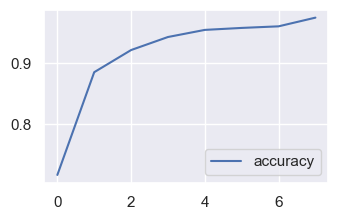

In [191]:
plt.plot(test_model.history.history["accuracy"], label="accuracy")
plt.legend()

In [192]:
best_params = study.best_params
# best_params = dict(n_conv=0, n_hidden=1, hidden_nodes=248, dropout=0.752200, filters=8, kernel_size=14, batch_size=19, epochs=75)

In [193]:
cnn = build_model((27,27), 2, **best_params)
cnn.summary()
cnn.fit( np.concatenate((X_train, X_val)), np.concatenate((y_train, y_val)), 
            epochs=best_params["epochs"], 
            batch_size=best_params["batch_size"])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_conv (Conv1D)          (None, 24, 13)            1417      
                                                                 
 batch_normalization_6 (Batc  (None, 24, 13)           52        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 24, 13)            0         
                                                                 
 extra_conv_0 (Conv1D)       (None, 21, 13)            689       
                                                                 
 batch_normalization_7 (Batc  (None, 21, 13)           52        
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 21, 13)           

42/42 [==============================] - 0s 8ms/step - loss: 0.0081 - accuracy: 0.9974
Epoch 50/90
42/42 [==============================] - 0s 12ms/step - loss: 0.0067 - accuracy: 0.9979
Epoch 51/90
42/42 [==============================] - 1s 15ms/step - loss: 0.0101 - accuracy: 0.9984
Epoch 52/90
42/42 [==============================] - 1s 16ms/step - loss: 0.0153 - accuracy: 0.9953
Epoch 53/90
42/42 [==============================] - 1s 12ms/step - loss: 0.0048 - accuracy: 0.9984
Epoch 54/90
42/42 [==============================] - 1s 12ms/step - loss: 0.0076 - accuracy: 0.9979
Epoch 55/90
42/42 [==============================] - 0s 11ms/step - loss: 0.0113 - accuracy: 0.9964
Epoch 56/90
42/42 [==============================] - 0s 11ms/step - loss: 0.0252 - accuracy: 0.9922
Epoch 57/90
42/42 [==============================] - 0s 11ms/step - loss: 0.0053 - accuracy: 0.9995
Epoch 58/90
42/42 [==============================] - 1s 12ms/step - loss: 0.0147 - accuracy: 0.9943
Epoch 59/90
4

In [194]:
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score

y_pred = np.argmax(cnn.predict(X_test), axis=1)

print(f'Cohen k {cohen_kappa_score(y_test, y_pred)}')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

17/17 [==============================] - 0s 2ms/step
Cohen k 0.9230769230769231
Accuracy 0.9615384615384616
F1-score [0.96153846 0.96153846]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       260
           1       0.96      0.96      0.96       260

    accuracy                           0.96       520
   macro avg       0.96      0.96      0.96       520
weighted avg       0.96      0.96      0.96       520



   # LIME Explainer 

## setting the classifier for explain_instance using the cnn

In [65]:
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries


In [ ]:
#To plot the heatmap
rgb_traces = []

for i in range(len(X_test)):
    trace = X_test[i].reshape(27,27)
    
    min_value = np.min(trace)
    max_value = np.max(trace)
    matrice_normalizzata = (trace - min_value) / (max_value - min_value)

    # Crea una matrice 27x27x3 con valori dei canali di colore basati sulla matrice normalizzata
    rosso = matrice_normalizzata
    verde = np.zeros_like(matrice_normalizzata)
    blu = np.zeros_like(matrice_normalizzata)
    heatmap = np.dstack((rosso, verde, blu))
    rgb_traces.append(heatmap)

rgb_traces = np.array([np.array(trace) for trace in rgb_traces])

In [195]:
explainer = lime_image.LimeImageExplainer()

In [196]:
import skimage
from skimage.color import gray2rgb, rgb2gray

def make_prediction(color_img):
    gray_img = rgb2gray(color_img).reshape(-1,27,27)
    preds = cnn.predict(gray_img)
    return preds

In [298]:
#Search for images that aren't full classified
indexes = []
for idx in range(20):
    explanation = explainer.explain_instance(gray2rgb(X_test[idx]), classifier_fn=make_prediction, num_samples=50)
    temp, mask = explanation.get_image_and_mask(1, num_features=10, hide_rest=False)
    if ((not np.all(mask==0))&(not np.all(mask==1))):
        print("Prediction : ", np.argmax(cnn.predict(X_test[idx].reshape(-1,27,27))))
        print(f"Actual : {y_test[idx]}       index:{idx}")
        indexes.append(idx)
explained = pd.DataFrame()
explained['Index'] = indexes
explained['Prediction'] = np.argmax(cnn.predict(X_test[indexes].reshape(-len(indexes),27,27)), axis=1)
explained['Actual'] = y_test[indexes]

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 14ms/step
Prediction :  1
Actual : 1       index:4


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step
Prediction :  0
Actual : 0       index:14


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step
Prediction :  0
Actual : 0       index:19
1/1 [==============================] - 0s 11ms/step


In [299]:
explained

,Index,Prediction,Actual
0,4,1,1
1,14,0,0
2,19,0,0


In [301]:
idx=0 #choose the index between 0-len(inedexes)
explanation = explainer.explain_instance(gray2rgb(X_test[indexes[idx]]), classifier_fn=make_prediction, num_samples=50)
temp, mask = explanation.get_image_and_mask(y_test[indexes[idx]], num_features=10, hide_rest=False)

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


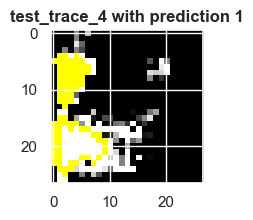

In [305]:
marked_image = mark_boundaries(temp , mask)
plt.title(f'test_trace_{indexes[idx]} with prediction { explained["Prediction"][idx] }')
plt.imshow(marked_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'LIME Explanation')

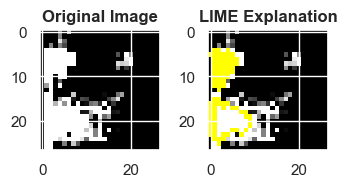

In [329]:
plt.subplot(1,2, 1)
plt.imshow(gray2rgb(X_test[indexes[0]]), cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(marked_image)
plt.title('LIME Explanation')

Text(0.5, 1.0, 'Heatmap')

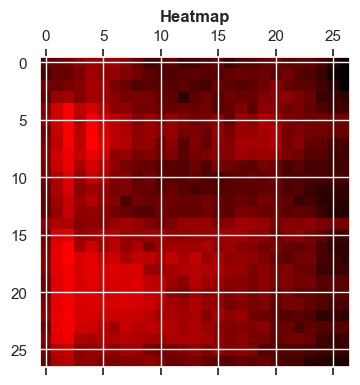

In [330]:

plt.matshow(rgb_traces_test[indexes[0]])
plt.title('Heatmap')